# HW12. Анализ временных рядов.
#### Ильичёв А.С., 693

In [5]:
import numpy as np
import math as m
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as sts
import pandas as pd
from statsmodels.stats.multitest import multipletests
import statsmodels as sm
from tqdm import tqdm
import scipy.interpolate as interp
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.model_selection import cross_val_score, KFold, GridSearchCV, train_test_split, ParameterGrid
from sklearn.metrics import mean_squared_error, make_scorer, accuracy_score
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
import sklearn.decomposition as decomp

import statsmodels.formula.api as smf
import statsmodels.tsa.api as smt
import statsmodels.api as sm
from statsmodels.tsa.stattools import kpss
from statsmodels.tsa.vector_ar.var_model import VARProcess


%matplotlib inline

plt.rcParams['figure.figsize'] = (14, 6) 

# Задача 2

In [6]:
df = pd.read_excel('hw12t2.xls', header=None)
df.head()

,0
0,0.012698
1,0.022681
2,-0.051218
3,-0.022244
4,-0.054943


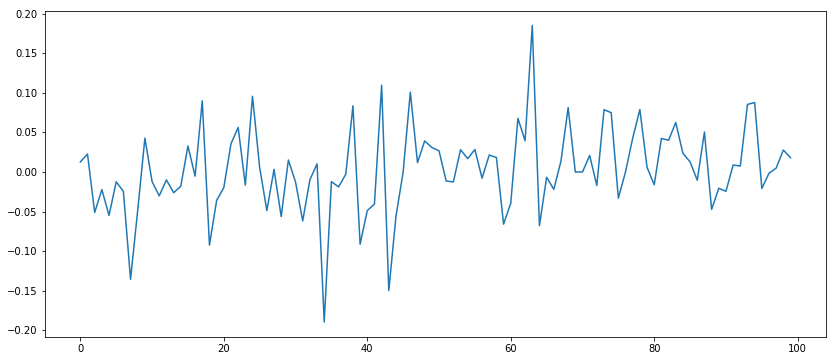

In [7]:
ts = df[0]
plt.plot(ts);

In [8]:
train = ts[:80]

Код для построения графиков с семинара:

In [9]:
def tsplot(y, lags=30, figsize=(12, 7), style='bmh'):
    if not isinstance(y, pd.Series):
        y = pd.Series(y)
    with plt.style.context(style):    
        fig = plt.figure(figsize=figsize)
        layout = (2, 2)
        ts_ax = plt.subplot2grid(layout, (0, 0), colspan=2)
        acf_ax = plt.subplot2grid(layout, (1, 0))
        pacf_ax = plt.subplot2grid(layout, (1, 1))

        y.plot(ax=ts_ax)
        ts_ax.set_title('Time Series Analysis Plots')
        smt.graphics.plot_acf(y, lags=lags, ax=acf_ax, alpha=0.5)
        smt.graphics.plot_pacf(y, lags=lags, ax=pacf_ax, alpha=0.5)

        print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(y)[1])

        plt.tight_layout()
    return 

Критерий Дики-Фуллера: p=0.000000


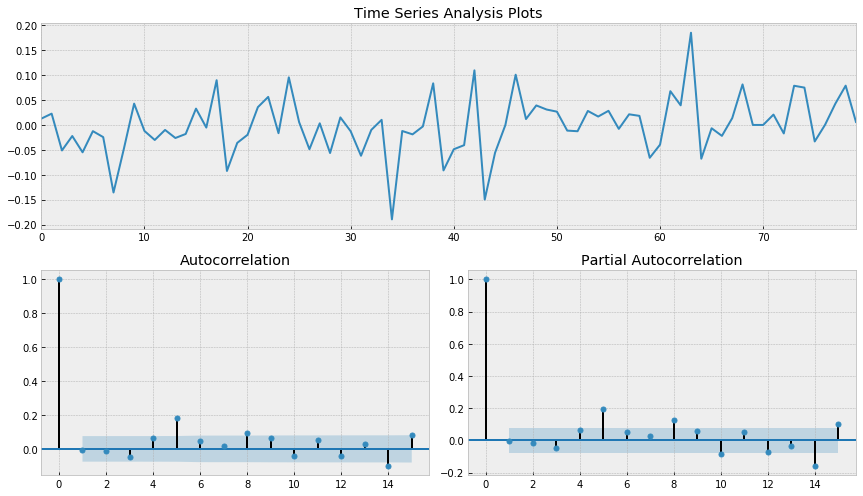

In [10]:
tsplot(train, lags=15)

Гипотеза наличия единичного корня отвергается. Лагов, близких к единице, нет. Но пятый лаг сравнительно большой, поэтому будем подбирать $p, q \le 5$, используя метрику BIC. 

In [11]:
grid = ParameterGrid({"p": np.arange(0,6),
                      "q": np.arange(0,6) })

In [12]:
import warnings
warnings.filterwarnings('ignore')

results = []
best_bic = np.inf
best_params = None
best_model = None
for params in grid:

    try:
        model=sm.tsa.ARIMA(train, order=(params['p'], 0, params['q']), ).fit(disp=-1)
    #выводим параметры, на которых модель не обучается и переходим к следующему набору
    except Exception:
        print('wrong parameters:', params)
        continue
    bic = model.bic
    #сохраняем лучшую модель, aic, параметры
    if bic < best_bic:
        best_model = model
        best_bic = bic
        best_params = params
    results.append([params, model.aic])
    
result_table = pd.DataFrame(results)
result_table.columns = ['parameters', 'bic']
    

wrong parameters: {'p': 1, 'q': 1}
wrong parameters: {'p': 1, 'q': 2}
wrong parameters: {'p': 1, 'q': 3}
wrong parameters: {'p': 1, 'q': 4}
wrong parameters: {'p': 1, 'q': 5}
wrong parameters: {'p': 2, 'q': 2}
wrong parameters: {'p': 2, 'q': 3}
wrong parameters: {'p': 2, 'q': 4}
wrong parameters: {'p': 2, 'q': 5}
wrong parameters: {'p': 3, 'q': 3}
wrong parameters: {'p': 3, 'q': 4}
wrong parameters: {'p': 3, 'q': 5}
wrong parameters: {'p': 4, 'q': 1}
wrong parameters: {'p': 4, 'q': 4}
wrong parameters: {'p': 4, 'q': 5}
wrong parameters: {'p': 5, 'q': 5}


In [13]:
result_table.sort_values(by = 'bic', ascending=True).head(10)

,parameters,bic
0,"{'p': 0, 'q': 0}",-225.600031
1,"{'p': 0, 'q': 1}",-223.602808
6,"{'p': 1, 'q': 0}",-223.602729
8,"{'p': 2, 'q': 1}",-221.707746
7,"{'p': 2, 'q': 0}",-221.619065
2,"{'p': 0, 'q': 2}",-221.618373
11,"{'p': 3, 'q': 2}",-220.787518
9,"{'p': 3, 'q': 0}",-219.801357
3,"{'p': 0, 'q': 3}",-219.764665
5,"{'p': 0, 'q': 5}",-219.601907


In [14]:
best_params

{'p': 0, 'q': 0}

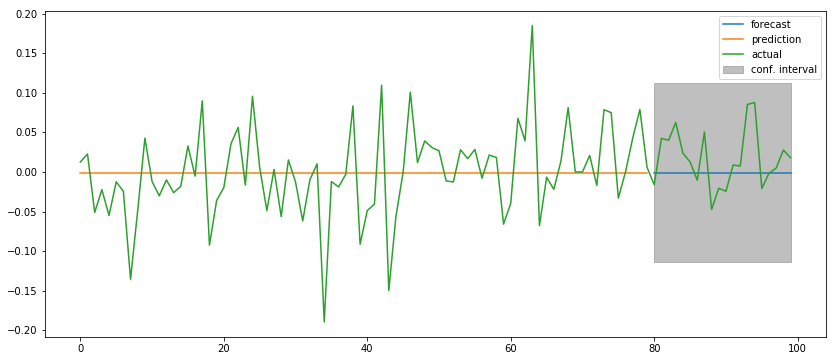

In [15]:
predictions = best_model.predict(start=1, end=len(train))
forecast, errs, conf_int = best_model.forecast(steps=20)
train_inds = np.arange(len(train))
test_inds = np.arange(len(train), len(ts))
plt.fill_between(test_inds, conf_int[:, 0], conf_int[:, 1], alpha=0.5, color='grey', label='conf. interval')
plt.plot(test_inds, forecast, label='forecast')
plt.plot(train_inds, predictions, label='prediction')
plt.plot(np.arange(len(ts)), ts, label='actual')
plt.legend()
plt.show()

Лучшими параметрами с точки зрения BIC оказались нули, то есть мы получили константную модель. Это произошло из-за того, что в данных не просматривается ни тренда, ни сезонности. Скорее всего, нам дан белый шум.

# Задача 3

In [25]:
df = pd.read_csv('hw12t3_train.csv', index_col=0)
df.head()

,y
0,2.186541
1,4.112926
2,2.342754
3,0.886390
4,1.538709


In [26]:
n = 260
k = 40
ts = df['y']
train = ts[:n]

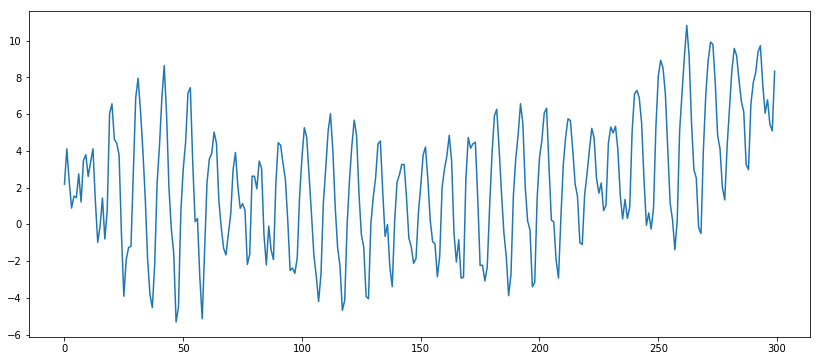

In [27]:
plt.plot(ts);

Видим некоторую гетероскедастичность в данных. Применим преобразование Бокса-Кокса.

Критерий Дики-Фуллера: p=1.000000
Оптимальный параметр преобразования Бокса-Кокса: 0.898300


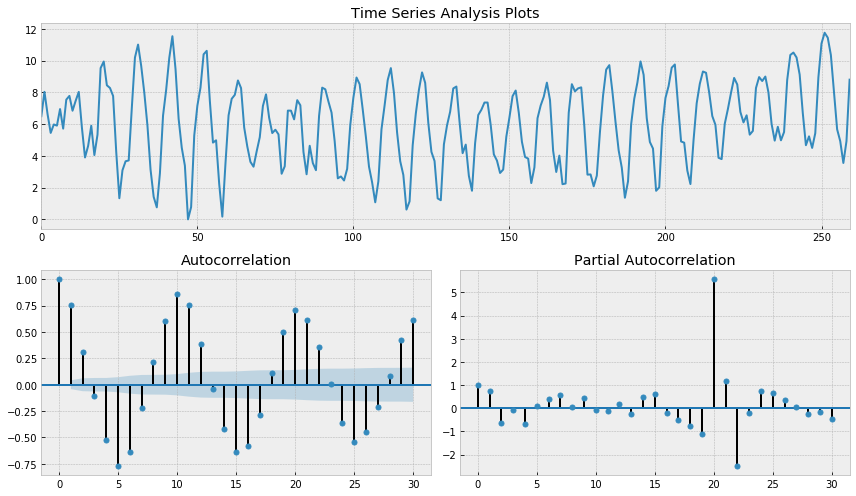

In [31]:
shift = np.min(train) - 1 # Data must be positive for boxcox transform
ts_boxcox, lmbda = sts.boxcox(train - shift)
ts_boxcox = pd.Series(ts_boxcox, index=train.index)
tsplot(ts_boxcox, lags=30)
print("Оптимальный параметр преобразования Бокса-Кокса: %f" % lmbda)

Двадцатый лаг самый большой, сделаем сезонное дифференцирование.

Критерий Дики-Фуллера: p=0.968207


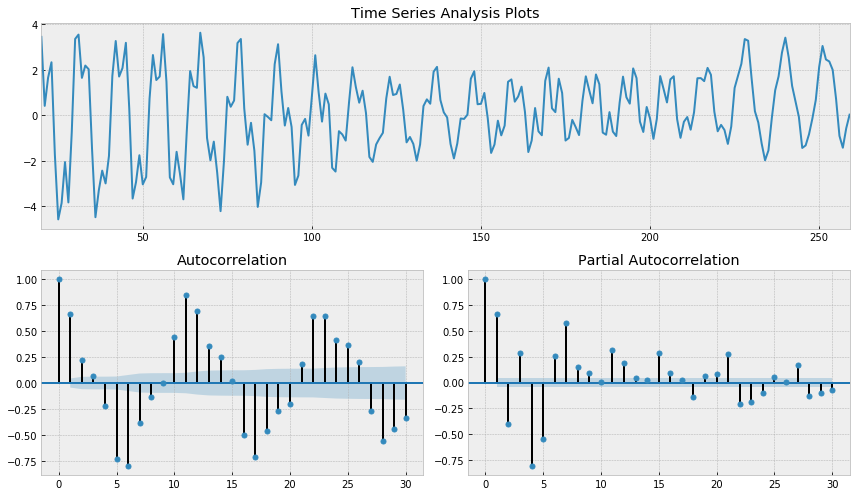

In [32]:
ts_season = ts_boxcox.diff(20)[20:]
tsplot(ts_season)

Первый лаг близок к 1, продифференцируем.

Критерий Дики-Фуллера: p=0.000000


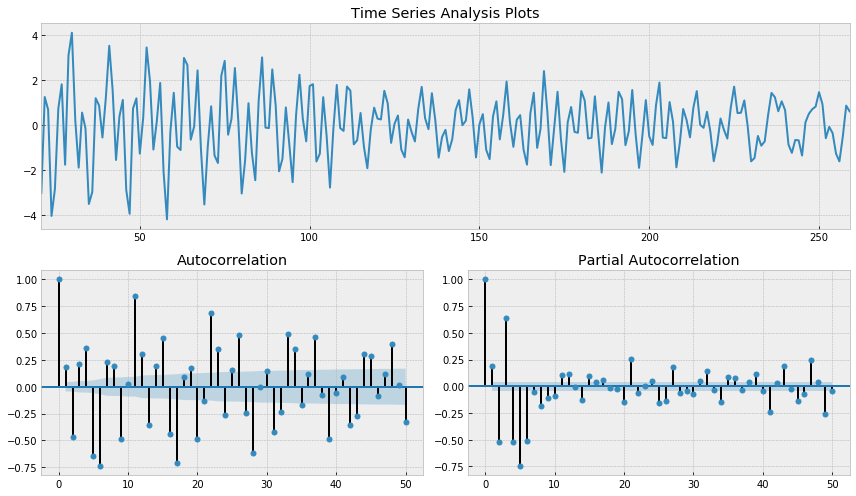

In [33]:
ts_diff = ts_season.diff(1)[1:]
tsplot(ts_diff, lags=50)

Гипотеза о нестационарности отверглась (хотя ACF выглядит не очень). Подберем параметры, взяв $p, q \le 6$.

In [34]:
from tqdm import tqdm

results = []
best_bic = np.inf
best_params = None
best_model = None
grid = ParameterGrid({"p": np.arange(0,7),
                      "q": np.arange(0,7),
                      "P": np.arange(0,5),
                      "Q": np.arange(0,1),
                       })

for params in tqdm(grid):
    try:
        model = sm.tsa.statespace.SARIMAX(ts_boxcox, order=(params['p'], 1, params['q']), 
                                        seasonal_order=(params['P'], 1, params['Q'], 20)).fit(disp=-1)
    except Exception:
#         print('wrong parameters:', params)
        continue
    bic = model.bic
    #сохраняем лучшую модель, aic, параметры
    if bic < best_bic:
        best_model = model
        best_bic = bic
        best_params = params
    results.append([params, model.aic])
    
result_table = pd.DataFrame(results)
result_table.columns = ['parameters', 'bic']

100%|██████████| 245/245 [15:13<00:00, 28.11s/it]


In [35]:
result_table.sort_values(by = 'bic', ascending=True).head(10)

,parameters,bic
61,"{'P': 2, 'Q': 0, 'p': 6, 'q': 5}",120.797058
78,"{'P': 3, 'Q': 0, 'p': 5, 'q': 5}",120.879950
57,"{'P': 2, 'Q': 0, 'p': 5, 'q': 5}",121.291417
82,"{'P': 3, 'Q': 0, 'p': 6, 'q': 5}",121.320550
40,"{'P': 1, 'Q': 0, 'p': 6, 'q': 5}",121.414093
83,"{'P': 3, 'Q': 0, 'p': 6, 'q': 6}",121.582626
36,"{'P': 1, 'Q': 0, 'p': 5, 'q': 5}",122.018298
62,"{'P': 2, 'Q': 0, 'p': 6, 'q': 6}",122.430109
99,"{'P': 4, 'Q': 0, 'p': 5, 'q': 5}",122.631584
103,"{'P': 4, 'Q': 0, 'p': 6, 'q': 5}",122.697430


In [60]:
predictions = best_model.predict(start=1, end=len(ts_boxcox))
forecast = best_model.get_prediction(1, len(ts) - 1)
predictions = forecast.predicted_mean
conf_int = forecast.conf_int()

Сделаем обратное преобразование Бокса-Кокса.

In [61]:
from scipy.special import inv_boxcox
predictions_inv = inv_boxcox(predictions, lmbda) + shift
lower_conf_int = inv_boxcox(conf_int['lower y'][21:], lmbda) + shift
upper_conf_int = inv_boxcox(conf_int['upper y'][21:], lmbda) + shift



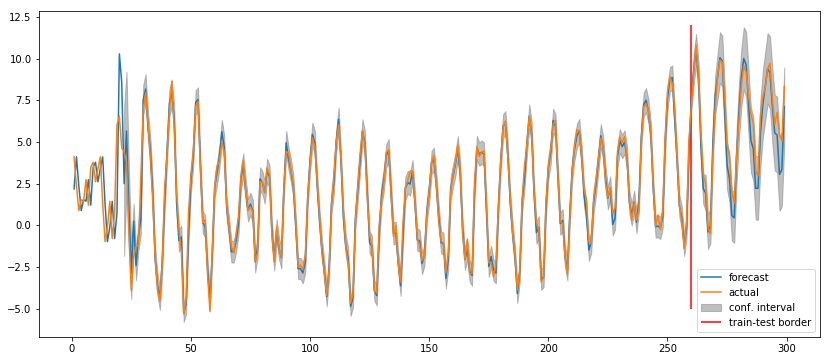

In [62]:
inds = np.arange(1, len(ts))
plt.fill_between(inds[21:], lower_conf_int, upper_conf_int, alpha=0.5, color='grey', label='conf. interval')
plt.plot(inds, predictions_inv, label='forecast')
plt.plot(inds, ts[1:], label='actual')
plt.vlines(260, -5, 12, colors='red', label='train-test border')
plt.legend()
plt.show()

Модель довольно хорошо описывает данные. Посчитаем U-коэффициент Тейла.

In [65]:
def u_tail(preds, gt):
    xn = gt[n - 1]
    return np.sqrt(np.sum((preds[n - 1:] -gt[n - 1:])**2)) / np.sqrt(np.sum((xn - gt[n - 1:])**2))

In [66]:
u_tail(predictions_inv, ts[1:])

0.2870506647737673

Построим модель с помощью метода экспоненциального сглаживания. Воспользуемся классом с семинара.

In [67]:
class HoltWinters:

    """
    Модель Хольта-Винтерса с методом Брутлага для детектирования аномалий
    https://fedcsis.org/proceedings/2012/pliks/118.pdf

    # series - исходный временной ряд
    # slen - длина сезона
    # alpha, beta, gamma - коэффициенты модели Хольта-Винтерса
    # n_preds - горизонт предсказаний
    # scaling_factor - задаёт ширину доверительного интервала по Брутлагу (обычно принимает значения от 2 до 3)

    """

    def __init__(self, series, slen, alpha, beta, gamma, n_preds, scaling_factor=1.96):
        self.series = series
        self.slen = slen
        self.alpha = alpha
        self.beta = beta
        self.gamma = gamma
        self.n_preds = n_preds
        self.scaling_factor = scaling_factor

    def initial_trend(self):
        sum = 0.0
        for i in range(self.slen):
            sum += float(self.series[i+self.slen] - self.series[i]) / self.slen
        return sum / self.slen  

    def initial_seasonal_components(self):
        seasonals = {}
        season_averages = []
        n_seasons = int(len(self.series)/self.slen)
        # вычисляем сезонные средние
        for j in range(n_seasons):
            season_averages.append(sum(self.series[self.slen*j:self.slen*j+self.slen])/float(self.slen))
        # вычисляем начальные значения
        for i in range(self.slen):
            sum_of_vals_over_avg = 0.0
            for j in range(n_seasons):
                sum_of_vals_over_avg += self.series[self.slen*j+i]-season_averages[j]
            seasonals[i] = sum_of_vals_over_avg/n_seasons
        return seasonals   

    def triple_exponential_smoothing(self):
        self.result = []
        self.Smooth = []
        self.Season = []
        self.Trend = []
        self.PredictedDeviation = []
        self.UpperBond = []
        self.LowerBond = []

        seasonals = self.initial_seasonal_components()

        for i in range(len(self.series)+self.n_preds):
            if i == 0: # инициализируем значения компонент
                smooth = self.series[0]
                trend = self.initial_trend()
                self.result.append(self.series[0])
                self.Smooth.append(smooth)
                self.Trend.append(trend)
                self.Season.append(seasonals[i%self.slen])

                self.PredictedDeviation.append(0)

                self.UpperBond.append(self.result[0] + 
                                      self.scaling_factor * 
                                      self.PredictedDeviation[0])

                self.LowerBond.append(self.result[0] - 
                                      self.scaling_factor * 
                                      self.PredictedDeviation[0])

                continue
            if i >= len(self.series): # прогнозируем
                m = i - len(self.series) + 1
                self.result.append((smooth + m*trend) + seasonals[i%self.slen])

                # во время прогноза с каждым шагом увеличиваем неопределенность
                self.PredictedDeviation.append(self.PredictedDeviation[-1]*1.01) 

            else:
                val = self.series[i]
                last_smooth, smooth = smooth, self.alpha*(val-seasonals[i%self.slen]) + (1-self.alpha)*(smooth+trend)
                trend = self.beta * (smooth-last_smooth) + (1-self.beta)*trend
                seasonals[i%self.slen] = self.gamma*(val-smooth) + (1-self.gamma)*seasonals[i%self.slen]
                self.result.append(smooth+trend+seasonals[i%self.slen])

                # Отклонение рассчитывается в соответствии с алгоритмом Брутлага
                self.PredictedDeviation.append(self.gamma * np.abs(self.series[i] - self.result[i]) 
                                               + (1-self.gamma)*self.PredictedDeviation[-1])

            self.UpperBond.append(self.result[-1] + 
                                  self.scaling_factor * 
                                  self.PredictedDeviation[-1])

            self.LowerBond.append(self.result[-1] - 
                                  self.scaling_factor * 
                                  self.PredictedDeviation[-1])

            self.Smooth.append(smooth)
            self.Trend.append(trend)
            self.Season.append(seasonals[i % self.slen])

In [68]:
smoothing = HoltWinters(ts_boxcox, 20, 0.9, 0.1, 0.5, k)
smoothing.triple_exponential_smoothing()

In [69]:
smoothing_inv = inv_boxcox(smoothing.result, lmbda) + shift
u_tail(smoothing_inv[1:], ts[1:])

0.4435148420471025

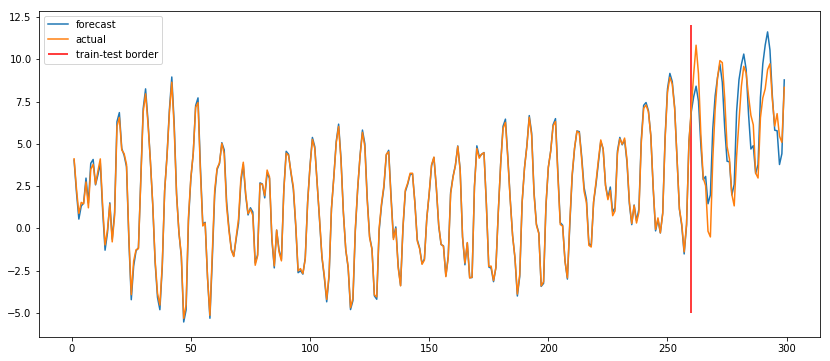

In [70]:
plt.plot(inds, smoothing_inv[1:], label='forecast')
plt.plot(inds, ts[1:], label='actual')
plt.vlines(260, -5, 12, colors='red', label='train-test border')
plt.legend()
plt.show()

Модель очень хорошо предсказывает уже известные данные, однако хороший прогноз требует тщательного подбора параметров. В данном случае мы получили результат хуже, чем у SARIMAX. Попробуем получить u-tail лучше. Выбор диапазона параметров обусловлен тем, что у нас слабо просматривается тренд (особенно в преобразованных Боксом-Коксом данных), а вот сезонность заметна.

In [71]:
grid = ParameterGrid({"alpha": np.linspace(0.8, 0.999, 20),
                      "beta": np.linspace(0.01, 0.2, 20),
                      "gamma": np.linspace(0.3, 0.8, 20),
                       })

best_u = 1000
best_preds = None

for params in tqdm(grid):
    smoothing = HoltWinters(ts_boxcox, 20, params['alpha'], params['beta'], params['gamma'], k)
    smoothing.triple_exponential_smoothing()
    smoothing_inv = inv_boxcox(smoothing.result, lmbda) + shift
    u = u_tail(smoothing_inv[1:], ts[1:])
    if u < best_u:
        best_u = u
        best_preds = smoothing_inv

100%|██████████| 8000/8000 [01:35<00:00, 95.41it/s] 


In [72]:
best_u

0.4316331522209518

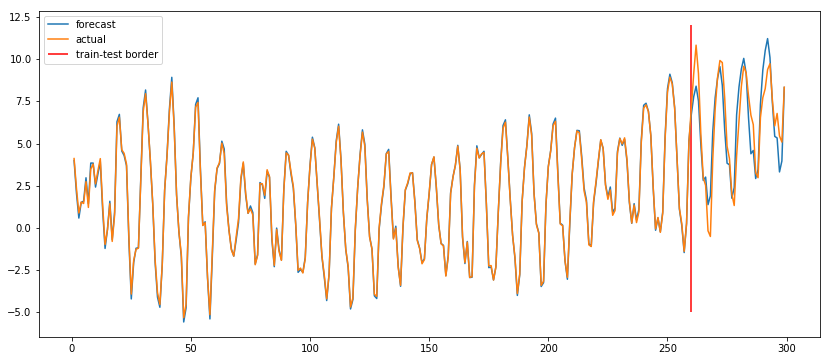

In [73]:
plt.plot(inds, best_preds[1:], label='forecast')
plt.plot(inds, ts[1:], label='actual')
plt.vlines(260, -5, 12, colors='red', label='train-test border')
plt.legend()
plt.show()

Результат лучше SARIMAX с точки зрения u-tail получить не удалось, хотя визуально прогноз выглядит неплохо.

# Задача 5

Получим модель AR(1). 
$$
X_t = a_1X_{t-1} + \varepsilon_t
$$
Используем , что $\varepsilon_t$ не коррелирует $X_s$ для всех $s, t$, а так же условие $cov(X_t, X_q) = e^{-|t-q|}$. Пусть s - величина шага (промежуток, через который мы берем значения непрерывного процесса для моделирования дискретного). То есть если $Y$ - непрерывный процесс, то $X_0 = Y_0, X_1 = Y_s, X_2 = Y_{2s}\dots$
$$
cov(X_t, X_{t-1}) = cov(a_1X_{t-1}, X_{t-1}) = a_1 = 1/e^s.
$$

Получим модель AR(2).
$$
X_t = a_1X_{t-1} + a_2X_{t-2} + \varepsilon_t
$$

$$
cov(X_t, X_{t-1}) = a_1 + a_2/e^s = 1/e^s
$$

$$
cov(X_t, X_{t-2}) = a_1/e^s + a_2 = 1/e^{2s}
$$

Из системы получаем $a_1=1/e^s, a_2 =0$, то есть процесс не описывается моделью AR(2) - мы получили снова AR(1).

Сгенерируем процесс с разными шагами.

In [74]:
def simulation(N, step, alpha = 1 / np.e):
    last = 0
    ts = []
    err = sts.norm(scale=1)
    for i in range(N):
        last = last * (alpha ** step) + err.rvs()
        ts.append(last)
    return ts

In [75]:
def plot_examples(N, step):
    inds = np.arange(0, N * step, step)
    for i in range(3):
        ts = simulation(N, step)
        plt.plot(inds, ts, alpha=0.7)
    plt.title(f'step = {step}')
    plt.show()

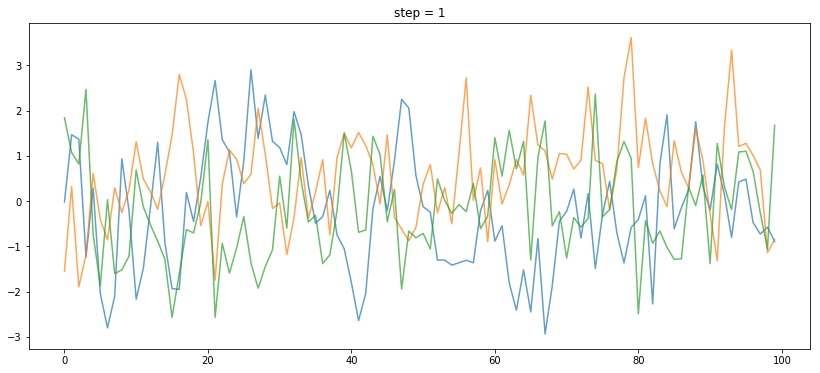

In [76]:
plot_examples(100, 1)

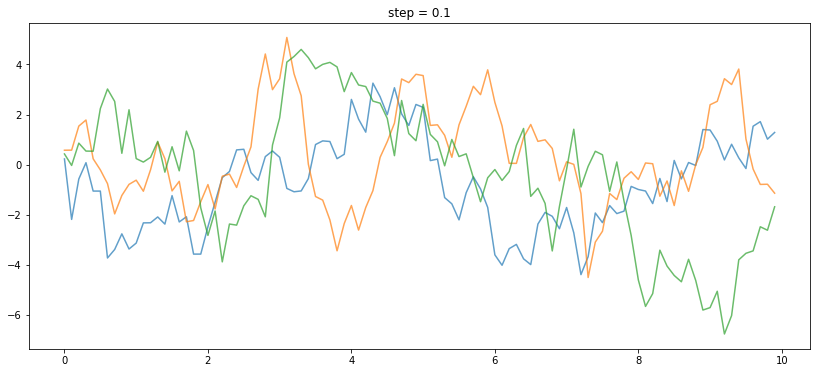

In [77]:
plot_examples(100, 1/10)

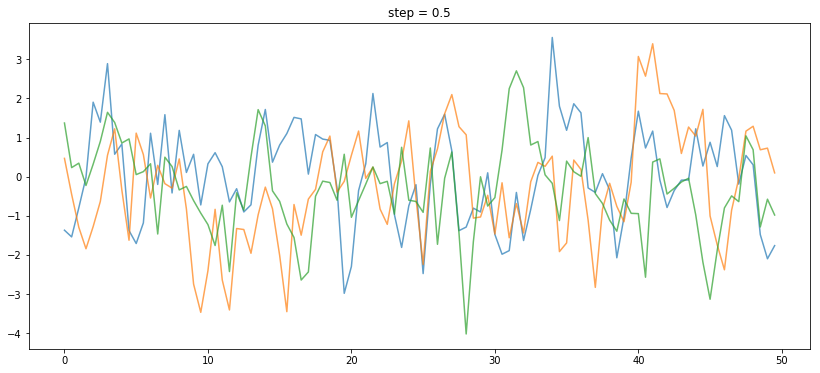

In [78]:
plot_examples(100, 1/2)

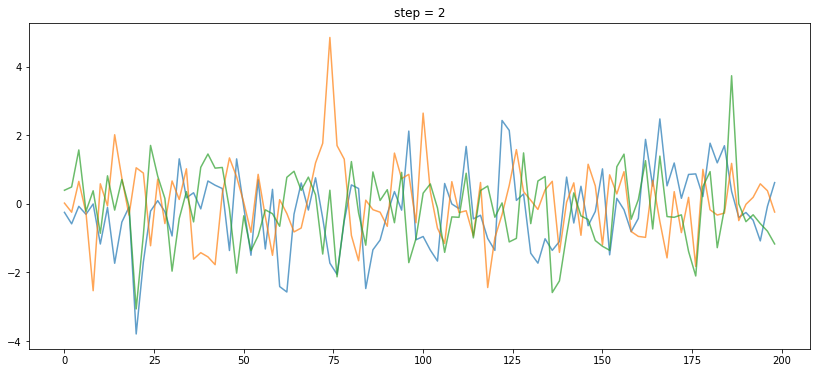

In [79]:
plot_examples(100, 2)

Оценим ковариационную функцию. Для уменьшения дисперсии оценки будем считать ее по 100 процессам и усреднять.

In [80]:
def estimate_R(process):
    N = len(process)
    rs = [np.dot(process, process) / N]
    for m in range(1, N):
        r = np.dot(process[:-m], process[m:]) / (N - m)
        rs.append(r)
    return np.array(rs)


In [83]:
def compare_Rs(N, step):
    rs = np.zeros(N)
    inds = np.arange(0, N * step, step)
    for i in range(100):
        process = simulation(N, step)
        rs += estimate_R(process)
    rs /= 100
    plt.plot(inds, rs, label='estimated')
    plt.plot(inds, np.exp(-inds), label='true')
    plt.legend()
    plt.title(f'step = {step}')
    plt.show()

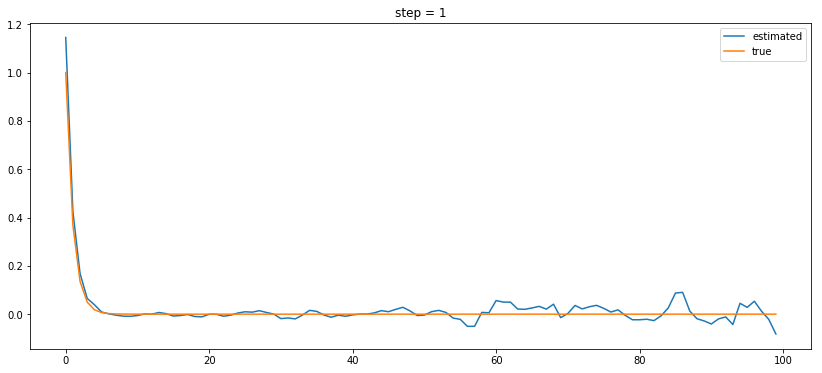

In [84]:
compare_Rs(100, 1)

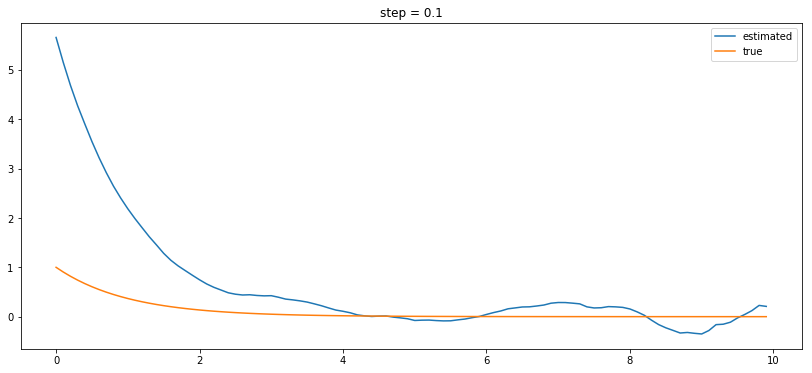

In [90]:
compare_Rs(100, 1/10)

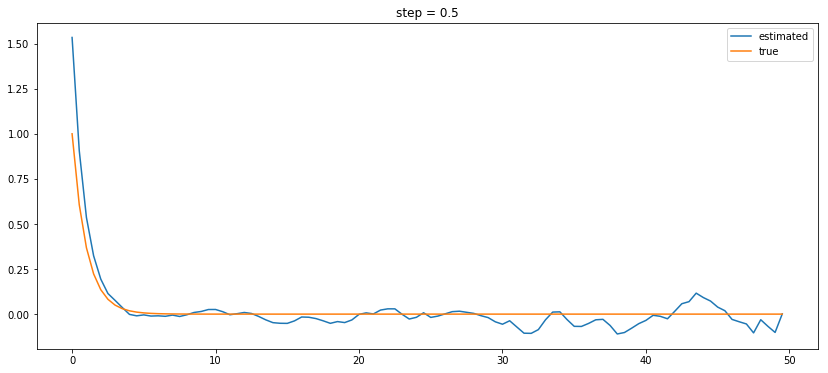

In [86]:
compare_Rs(100, 1/2)

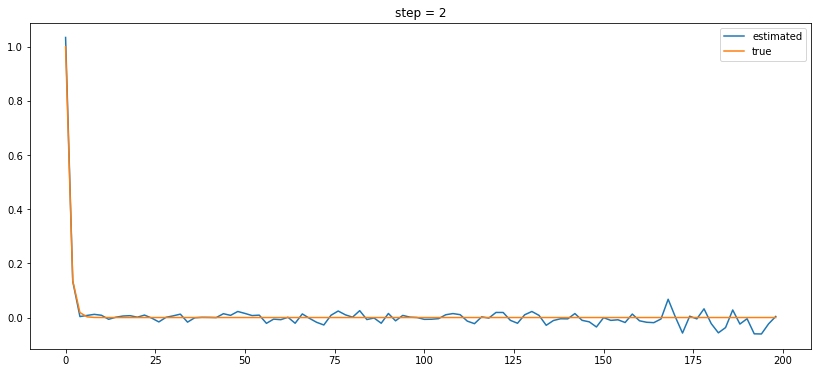

In [91]:
compare_Rs(100, 2)

Чем больше шаг моделирования, тем ближе получаются оценки к истинному значению. Тем не менее, оценка довольно сильно колеблется. Скорее всего, это связано с тем, что мы взяли большую дисперсию белого шума в AR-модели.